<IPython.core.display.Javascript object>


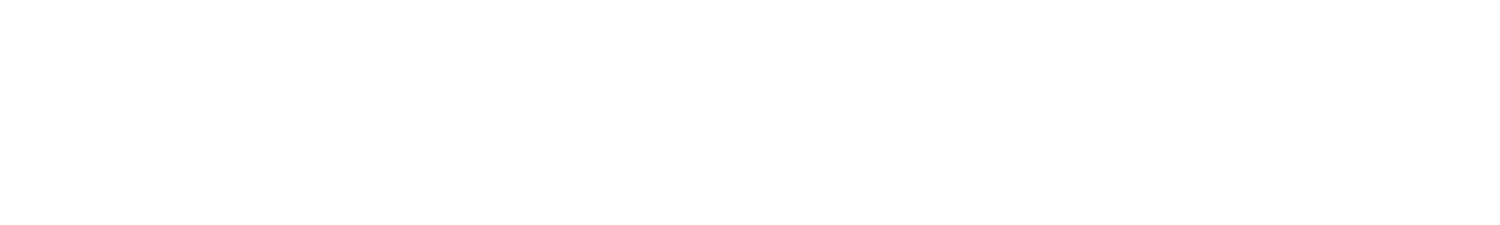

C:\Users\Huayi\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.


,RecN,Ra,Rinput
0,0.0,19.939476,140.673682
1,6.0,104.810838,257.305676
2,7.0,49.987129,190.547522
3,12.0,59.367998,273.047383
4,13.0,53.233417,231.058784


In [10]:
from util0 import *
import matplotlib.pyplot as plt
import numpy as np
import os, errno
import pandas as pd
%matplotlib nbagg

## read in all the channels
# name of the folder & the file
fdname = '051419fly1cell2'
celltype = 'HS_L'

#first check Ra, Rinput
RecVlist = [0,6,7,12,13]

year = '2019'
date = fdname[:2]+'_'+fdname[2:4]
fdname = '%s/%s' %(celltype,fdname)

def RaRi(RecVlist,fdname):
    R = np.zeros((len(RecVlist),3))
    for n,i in enumerate(RecVlist):
        t,v,pho = readtraces(fdname, i)  
        dt = t[1]-t[0]
        baseline = np.mean(v[:int(0.005/dt)])#np.mean(v[:int(0.003/dt)])
        Ra = 10/abs(min(v)-baseline)*1000
        Rinpt = 10/abs(np.mean(v[int(0.019/dt):int(0.020/dt)])-baseline)*1000#10/abs(np.mean(v[int(0.007/dt):int(0.008/dt)])-baseline)*1000
        R[n][0] = i
        R[n][1] = Ra
        R[n][2] = Rinpt
    #     print('Rec%d: Ra is %f Mohm' %(i,Ra))
    #     print('      Rinput is %f Mohm' %Rinpt)
    Rdf = pd.DataFrame(R)
    Rdf.columns = ['RecN','Ra','Rinput']
    #save
    dir_aligned = 'Analysis/%s'%fdname+'/aligned/Isteps'
    try:
        os.makedirs(dir_aligned)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
    Rdf.to_pickle(dir_aligned+'/RaRinput.ASCII')
    
    from pandas.tools.plotting import table
    plt.figure(figsize = [10,1+0.1*len(RecVlist)])
    ax = plt.subplot(111, frame_on=False) # no visible frame
    ax.xaxis.set_visible(False)  # hide the x axis
    ax.yaxis.set_visible(False)  # hide the y axis

    table(ax, Rdf,loc='center')  # where df is your data frame
    
    dir_pic = 'Pics/%s'%fdname+'/Isteps'
    try:
        os.makedirs(dir_pic)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
    
    plt.savefig(dir_pic+'/RaRinput.jpeg')
    plt.close()
    return(Rdf)

RaRi(RecVlist,fdname)

Cell sitting around -36.120495 mV


<IPython.core.display.Javascript object>


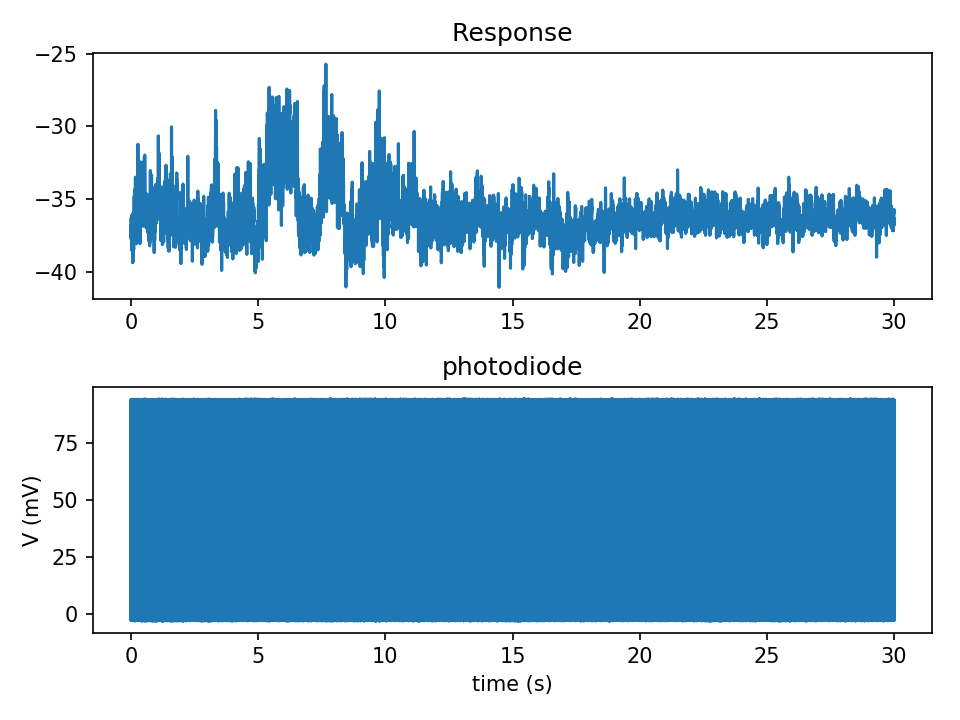

<IPython.core.display.Javascript object>


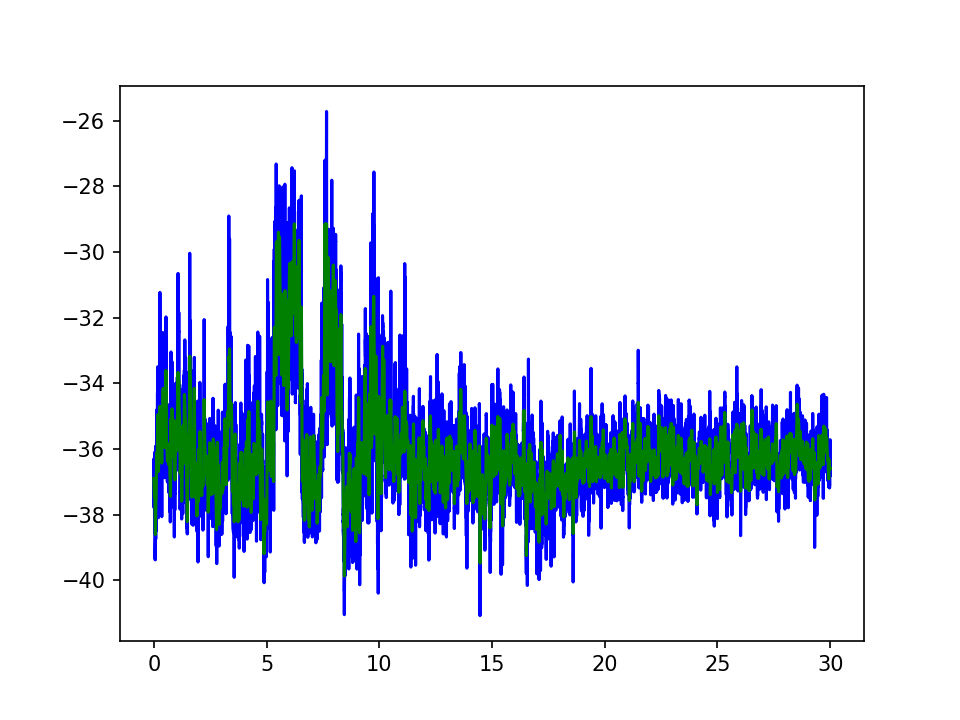

In [11]:
# Then, check resting Vm, resting fring rate 
RecIo = 1
spiking = False
%matplotlib nbagg


t,v,pho = readtraces(fdname, RecIo) 
ta,tb = 0,int(len(t)) # range for plotting. 0,len(t) is start to end.

dt = t[1]-t[0] 

if spiking: 
    th1 = 0.13#0.12 #0.15
    th2 = 3#5#2
    spike_idx = detectAP(v[ta:tb],t[ta:tb],th1,th2)
    BFrate = len(spike_idx)/30
    print('Baseline fring rate is %f Hz' %BFrate)
else: 
    spike_idx = False
    BVm = FiltV(v,3,0.001)
    Vm = np.mean(BVm)
    print('Cell sitting around %f mV' %Vm)

plotrange(t,ta,tb,v,pho,spike_idx)
plt.figure()
plt.plot(t,v,'b')
plt.plot(t,BVm,'g')
plt.show()


<IPython.core.display.Javascript object>


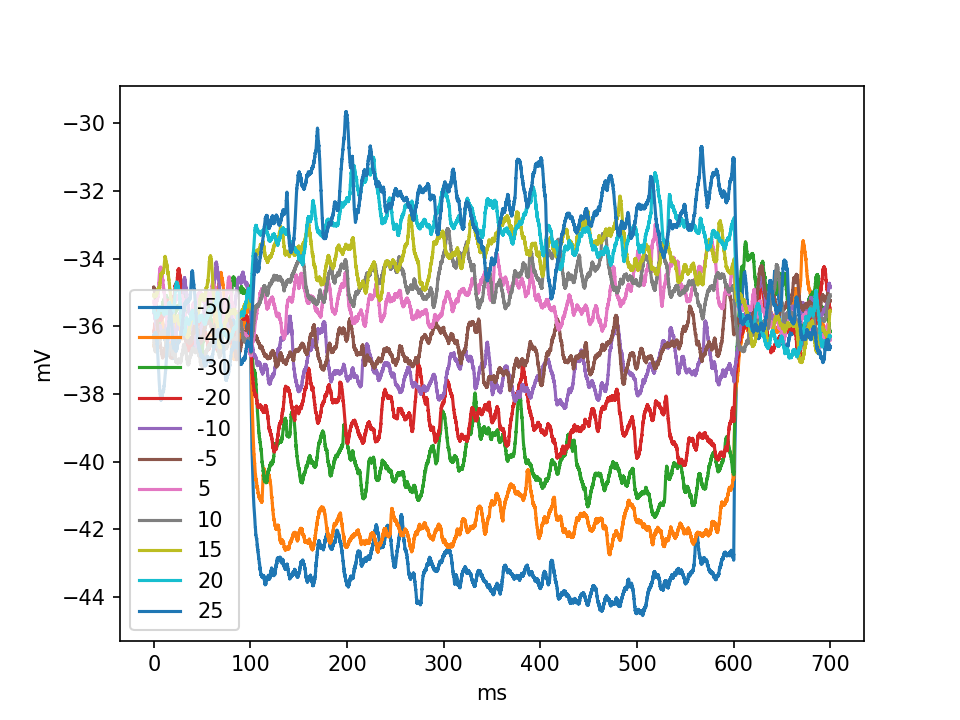

<IPython.core.display.Javascript object>


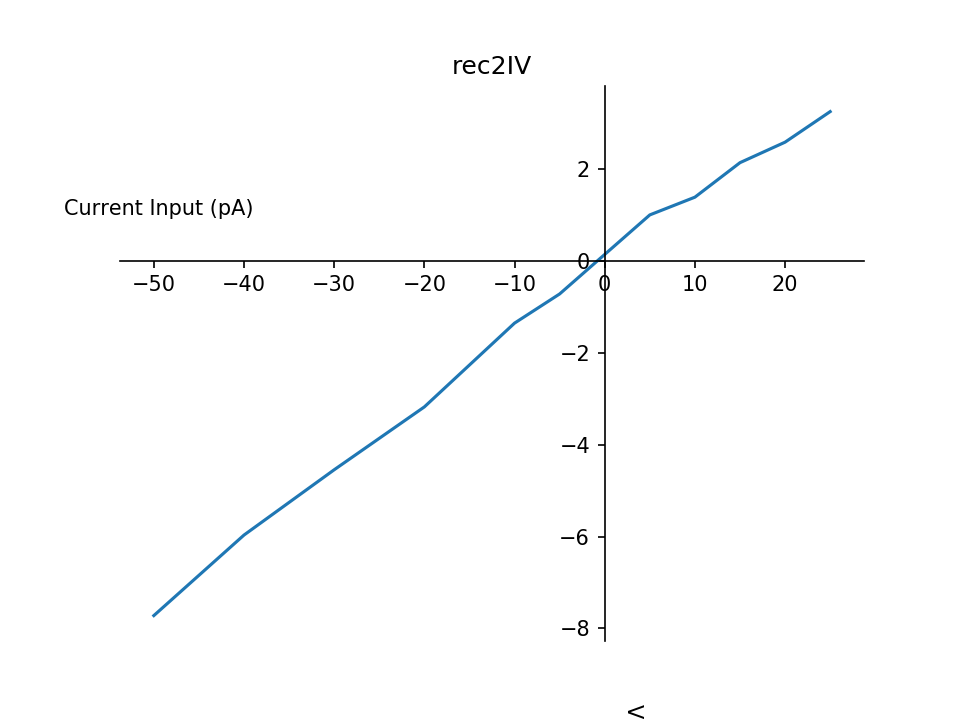

<IPython.core.display.Javascript object>


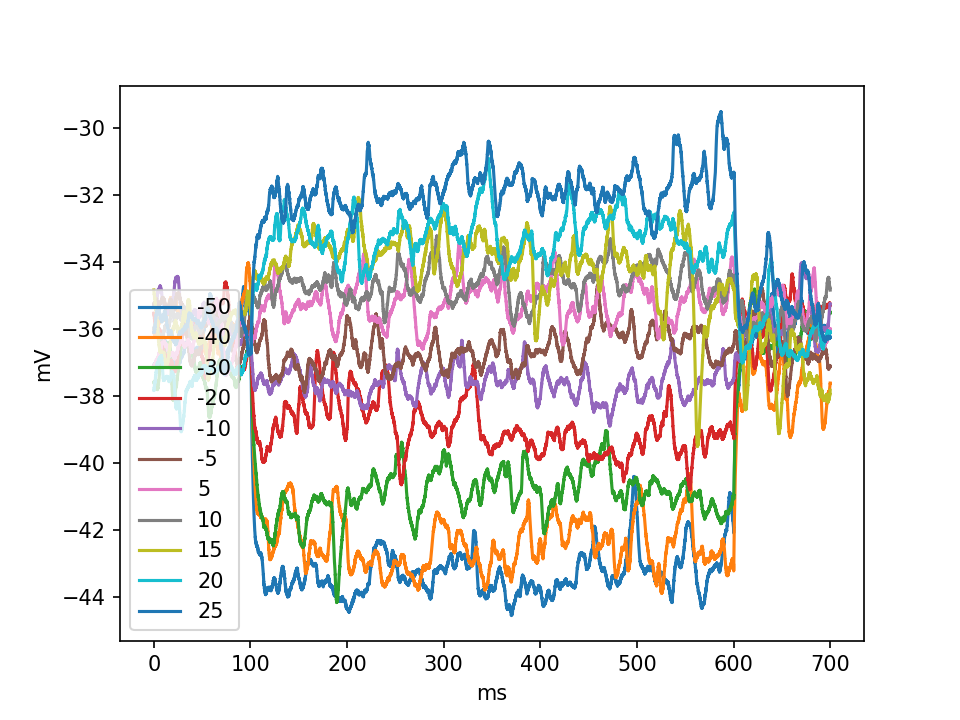

<IPython.core.display.Javascript object>


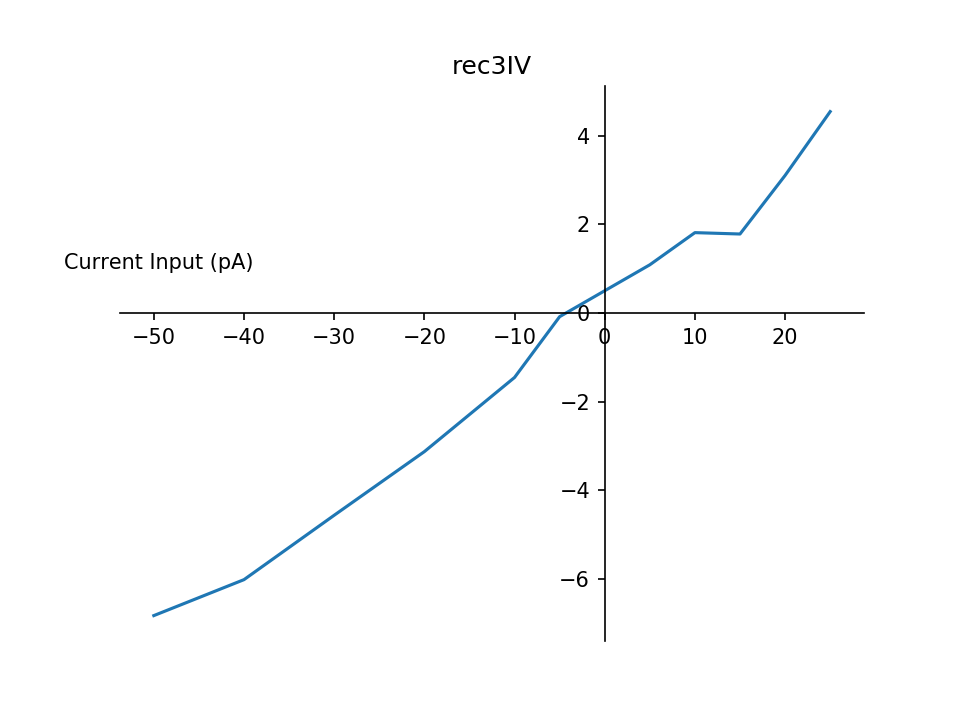

In [12]:
# Lastly, plot IF curve

RecIstp = [2,3]
StpName= "Istep0b"
Ihold = 0
#"Istep0"
#"Istep0a"
#"Istep0aaa" 
#"Istep0b"
def checkStpName(StpName, Ihold):
    if StpName == "Istep0":
        steps=np.append(np.arange(-50,-9,10),[-5,5])
    elif StpName == "Istep0a":
        steps=np.append(np.arange(-50,-9,10),np.append(-5, np.arange(5,16,5)))
    elif StpName == "Istep0aaa":
        steps=np.append(np.arange(-100,-19,20),[-10,5,10,15])
    elif StpName == "Istep0b":
        steps=np.append(np.arange(-50,-9,10),np.append(-5, np.arange(5,26,5)))
    elif StpName == "Istep0bb":
        steps=np.append(np.arange(-50,-9,10),np.append(-5, np.arange(5,26,5)))
    elif StpName == "Istep0bbb":
        steps=np.append(np.arange(-20,-9,5),np.append(-5, np.arange(5,41,5)))
    steps = steps + Ihold
    return(steps)

th1 = 0.075 #0.15
th2 = 8#2

for i in RecIstp:
    steps = checkStpName(StpName,Ihold); t,v,pho = readtraces(fdname, i); dt = t[1]-t[0]
    #print(th1,th2)
    spike_idx = detectAP(v,t,th1,th2)

    intv = int(0.5/dt); refsize = int(0.10/dt); totalsize = intv+refsize*2
   
    # plot to check step commend
    tp = np.linspace(0,(0.5+0.1*2)*1000, totalsize)
    # plt.figure(); S = np.zeros([len(steps), totalsize])
    # for ni,i in enumerate(steps): 
    #     S[ni,refsize:-refsize] = np.ones(intv)*i; plt.plot(t,S[ni,:])
    # plt.xlabel('ms'); plt.ylabel('pA'); plt.show()    
    
    nS=len(steps); stepv = np.zeros([nS, totalsize]); APn = np.zeros(len(steps)); 
    Vn = np.zeros(len(steps)); Vn_base = np.zeros(len(steps))
    plt.figure()
    for j in range(1,nS+1):
        stepv[j-1,:] = v[totalsize*(j-1):totalsize*j]; plt.plot(tp,stepv[j-1,:])
        if spiking: 
            s_idx = spike_idx[np.where((spike_idx>totalsize*(j-1)) &(spike_idx<totalsize*j))]-totalsize*(j-1)  
            s_idx = s_idx[np.where((s_idx>(refsize+10)) &(s_idx<(refsize+intv)))]
            APn[j-1] = np.sum((s_idx>0)); plt.scatter(tp[s_idx],stepv[j-1,:][s_idx], c = 'r')
        else:
            Vn[j-1]  = np.mean(stepv[j-1,:][-int(intv/5*2+refsize):-refsize])
            Vn_base[j-1] = np.mean(stepv[j-1,:][:refsize])
    Vn = Vn - np.mean(Vn_base)       
    plt.xlabel('ms'); plt.ylabel('mV'); plt.legend(steps[:nS],loc=3)
    plt.savefig('Pics/%s'%fdname+'/Isteps/rec%dIstep.jpeg'%i)
    plt.show(); plt.figure()
    if spiking:
        APr = APn/0.5 # in HZ
        APrdf=pd.DataFrame(data=np.column_stack((steps,APn)), columns = ('steps','APRate'))
        APrdf.to_pickle('Analysis/%s'%fdname+'/aligned/Isteps/rec%dIF.ASCII'%i)   
        plt.plot(steps,APn); plt.title('rec%dIF'%i); plt.ylabel('firing rate (Hz)'); plt.xlabel('Current Input (pA)')
        plt.savefig('Pics/%s'%fdname+'/Isteps/rec%dIF.jpeg'%i)
    else:
        plt.plot(steps,Vn); plt.title('rec%dIV'%i); 
        ax = plt.gca(); ax.spines['right'].set_color('none'); ax.spines['top'].set_color('none')
        ax.xaxis.set_ticks_position('bottom'); ax.spines['bottom'].set_position(('data',0))
        ax.yaxis.set_ticks_position('left'); ax.spines['left'].set_position(('data',0))
        plt.text(2,-10,'Vm (mV)',rotation=-90); plt.text(-60,1,'Current Input (pA)')
        plt.savefig('Pics/%s'%fdname+'/Isteps/rec%dIV.jpeg'%i)        
    plt.show()

